# July 30th, 2018
## Benjamin Adam Catching
## Andino Lab, Summer Rotation
## Polio-virus DIPs Project

There appear to be some issues with finding cells in the 40X images. For now, use the 10X images.

In [107]:
# Import necessary packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import skimage.measure
import skimage.filters
import skimage.morphology
import scipy.ndimage as ndi
import scipy
import pandas as pd

In [2]:
# Set the image directory based on if working on notebook in pycharm or not
in_pycharm = False
if in_pycharm:
    bulk_cell_dir = 'data/07.27_HeLa_TIP_Hong/'
else:
    bulk_cell_dir = '../../data/07.27_HeLa_TIP_Hong/'
    
# Define the six directories that contain image files
set_1 = '#1/10x-[0-9].tif'
set_2 = '#2/10x-[0-9].tif'
set_3 = '#3/10x-[0-9].tif'
set_4 = '#4/10x-[0-9].tif'
set_5 = '#5/10x-[0-9].tif'

In [3]:
# Read in the files
group_1 = sorted(glob.glob(bulk_cell_dir + set_1))
group_2 = sorted(glob.glob(bulk_cell_dir + set_2))
group_3 = sorted(glob.glob(bulk_cell_dir + set_3))
group_4 = sorted(glob.glob(bulk_cell_dir + set_4))
group_5 = sorted(glob.glob(bulk_cell_dir + set_5))

In [4]:
group_2

['../../data/07.27_HeLa_TIP_Hong/#2/10x-1.tif',
 '../../data/07.27_HeLa_TIP_Hong/#2/10x-2.tif',
 '../../data/07.27_HeLa_TIP_Hong/#2/10x-3.tif']

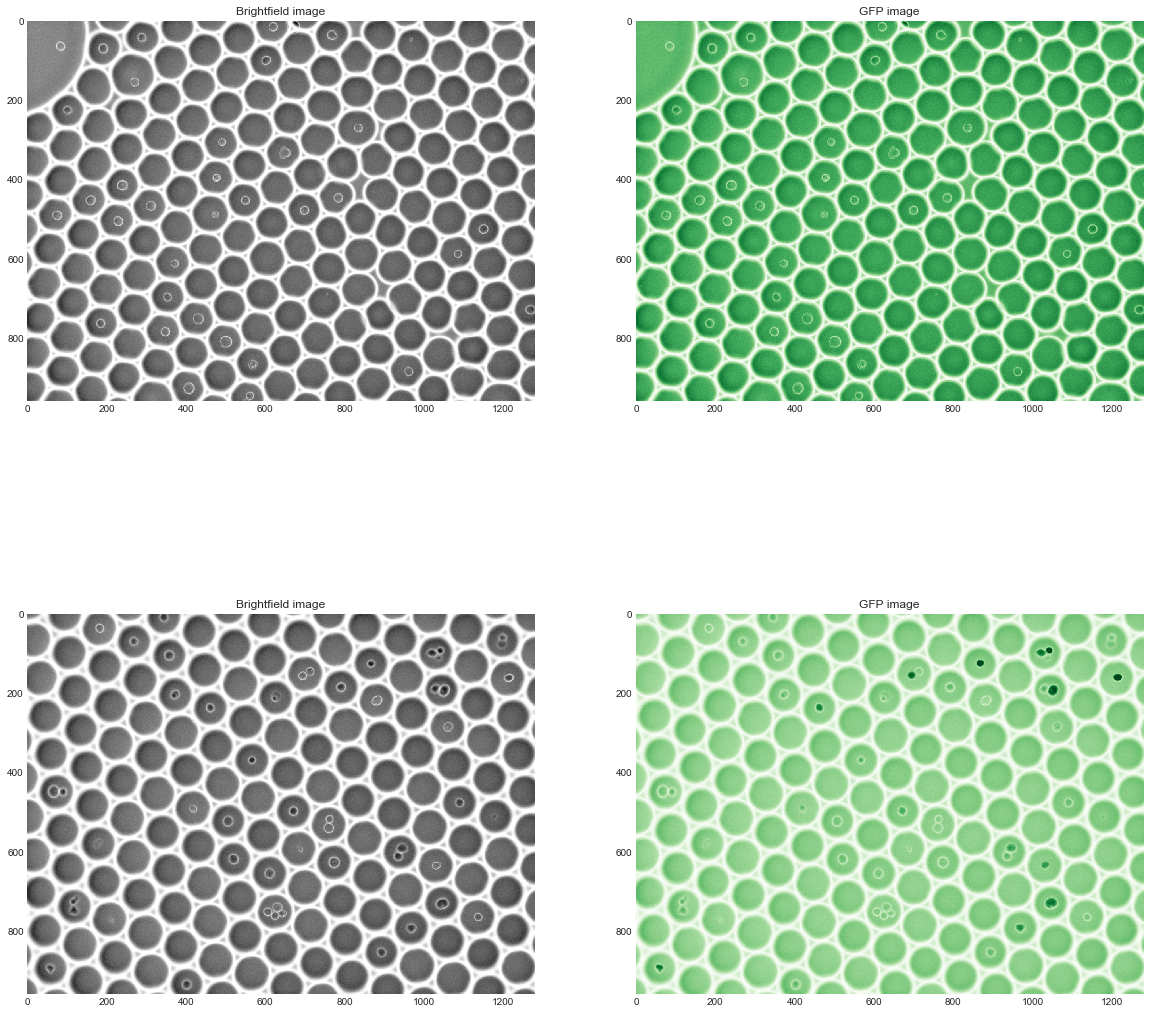

In [106]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax[0, 0].imshow(skimage.io.imread(group_4[0])[:, :, 0], cmap=plt.cm.Greys)
    ax[0, 0].set_title('Brightfield image')
    ax[0, 1].imshow(skimage.io.imread(group_4[0])[:, :, 1], cmap=plt.cm.Greens)
    ax[0, 1].set_title('GFP image')
    ax[1, 0].imshow(skimage.io.imread(group_2[1])[:, :, 0], cmap=plt.cm.Greys)
    ax[1, 0].set_title('Brightfield image')
    ax[1, 1].imshow(skimage.io.imread(group_2[1])[:, :, 1], cmap=plt.cm.Greens)
    ax[1, 1].set_title('GFP image')
    plt.show()

In [6]:
# Read in the microfluids analysis 
import microfluidics_analysis as ma

In [7]:
test_segment = ma.BulkDroplet(group_1[0], micron_per_pixel=0.899, gfp_thresh=50, multi_channel=True)

In [128]:
# Read in the brightfield and GFP images
image_bright = skimage.io.imread(group_2[0])[:, :, 0]
image_gfp = skimage.io.imread(group_2[0])[:, :, 1]
# Find the Otsu threshold
bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

# Label thesholded images
bright_threshold = image_bright > bright_thresh_otsu
image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)

# Get the properties of the labeled regions
image_props = skimage.measure.regionprops(image_labeled)

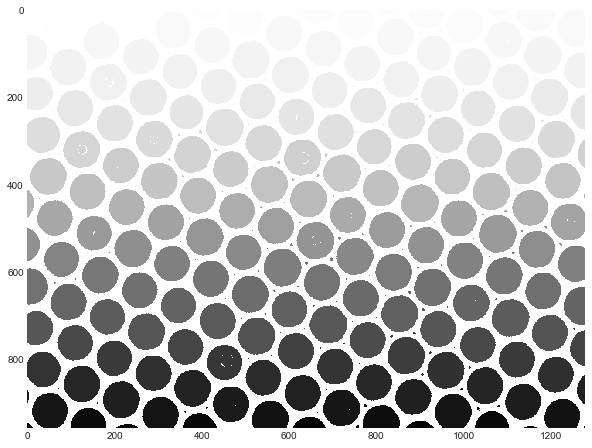

In [129]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image_labeled, cmap=plt.cm.Greys)
    plt.show()

In [130]:
# Create a blank region of the original image
image_dimensions = image_bright.shape
blank_background= np.zeros(image_dimensions)
# Go through props
for index, prop in enumerate(image_props):
    # If the region properties are within the threshold
    if prop.area >= 400 and prop.eccentricity <= 0.5:
        # Select the region
        temp_seg = image_labeled==index+1
        filled_seg = temp_seg
        # Add the temp region
        blank_background = blank_background + filled_seg

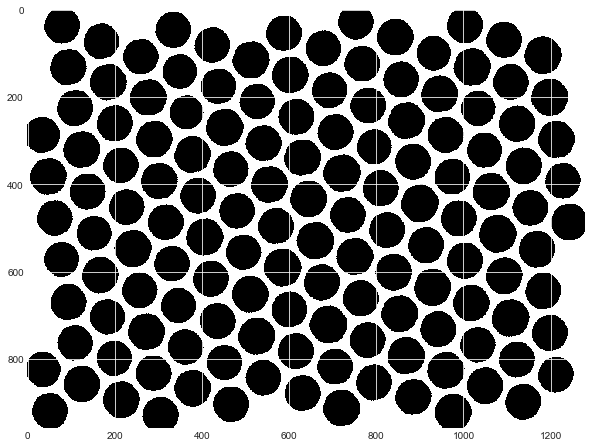

In [131]:
# Fill the holes of the image
image_droplets = ndi.binary_fill_holes(blank_background)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image_droplets, cmap=plt.cm.Greys)
    plt.show()

In [132]:
# From the filled droplets, create labeled regions with properties
labeled_droplets, number_droplets = skimage.measure.label(image_droplets, background=0, return_num=True)
bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
gfp_droplet_props = skimage.measure.regionprops(labeled_droplets, image_gfp)

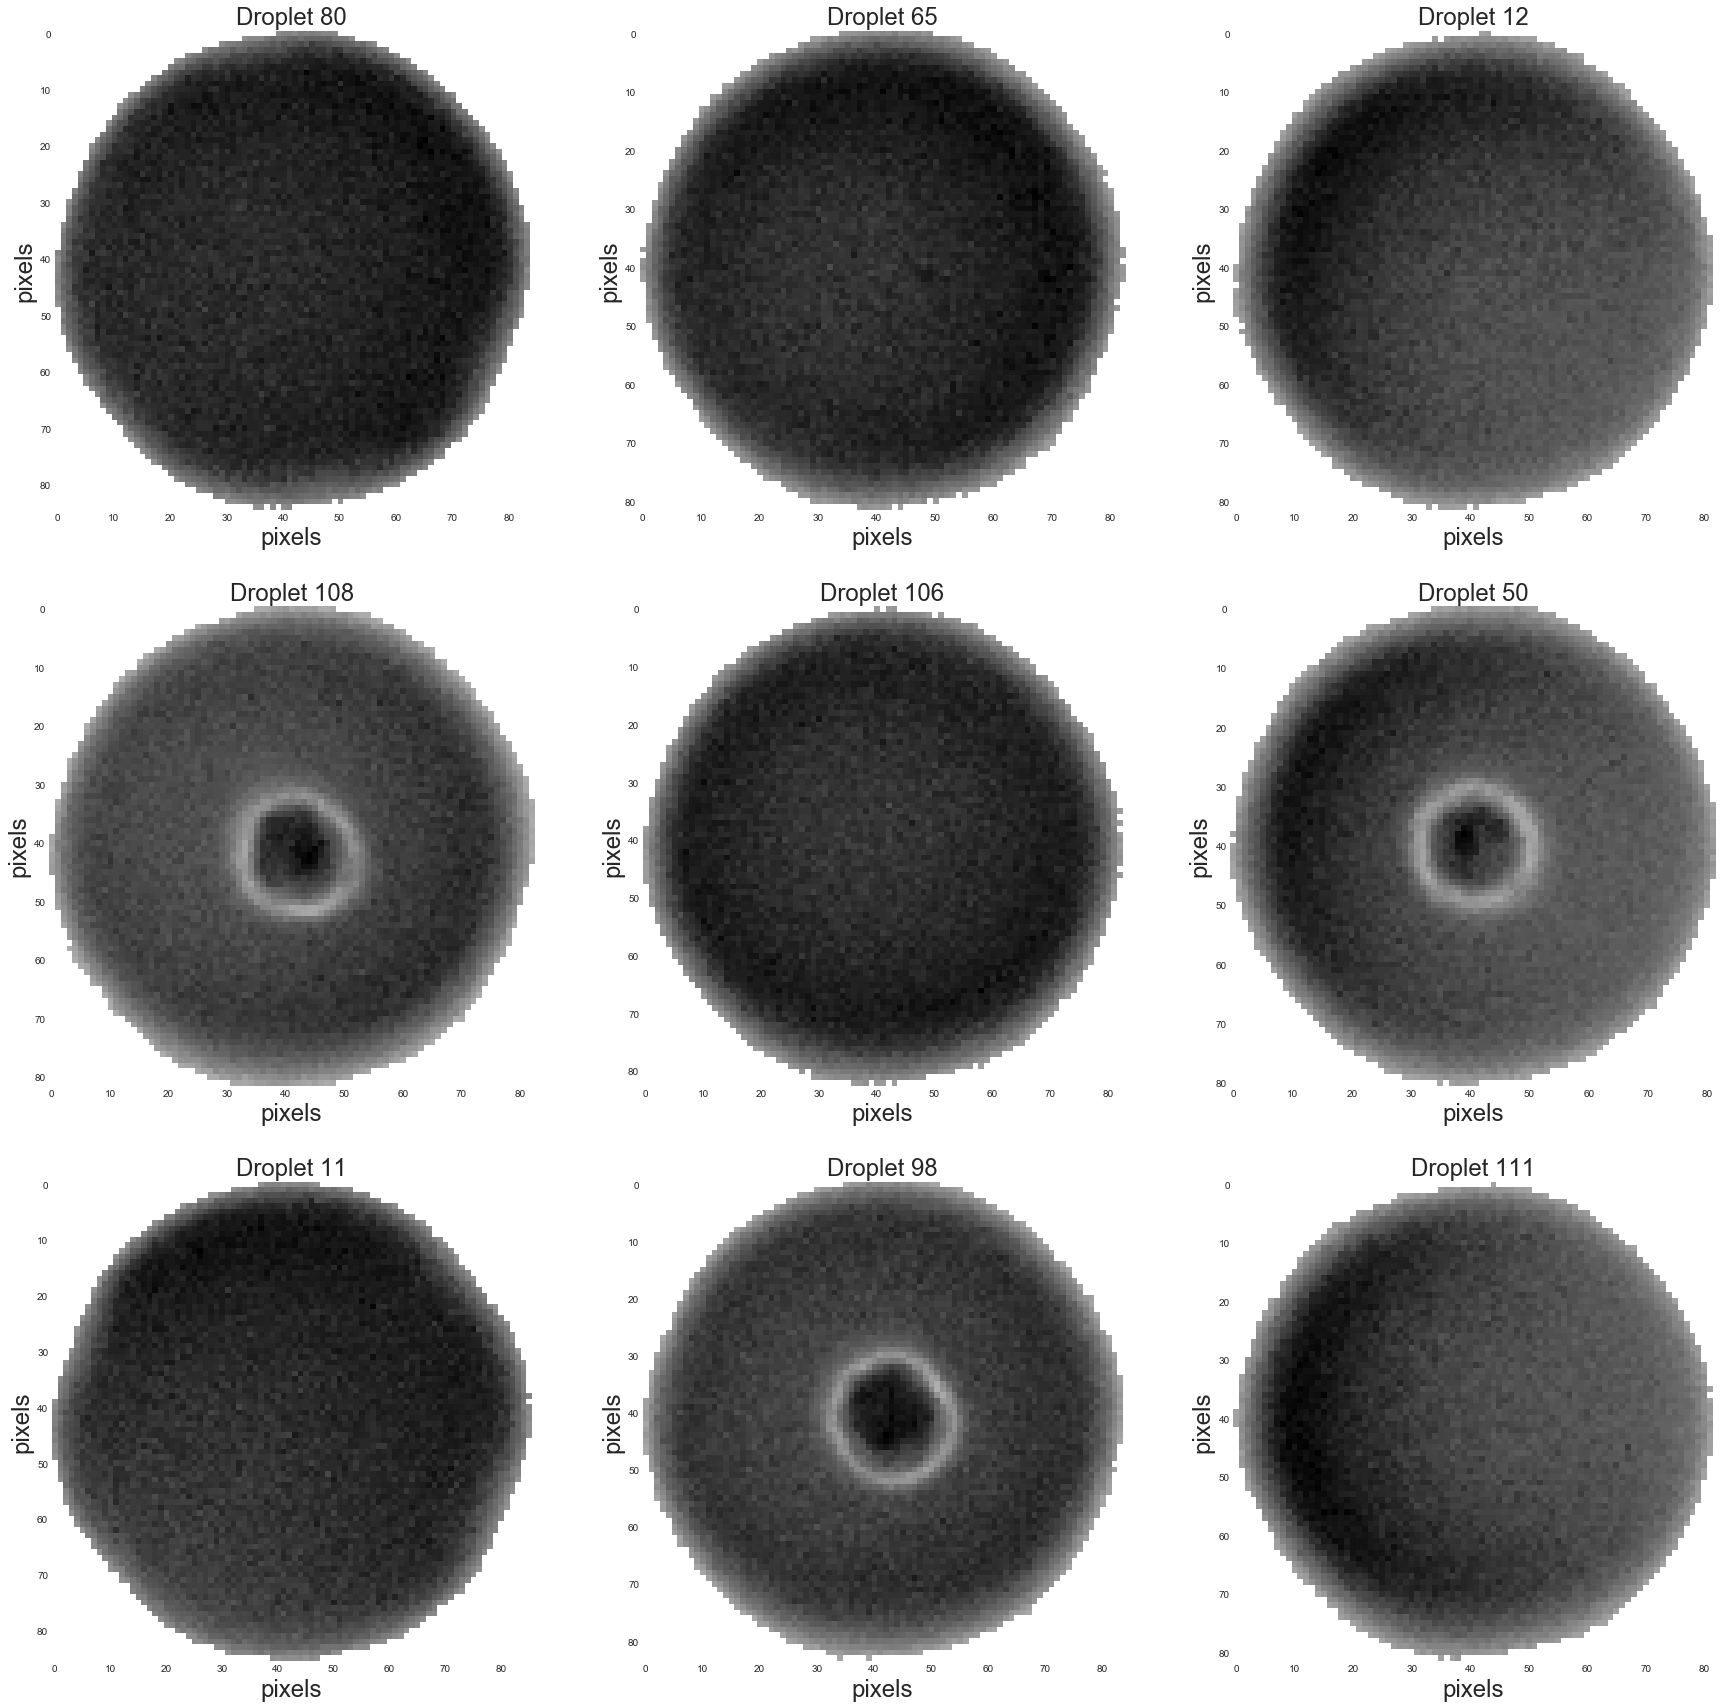

In [148]:
# Show 9 random droplets

# Choose the set of random droplets that will be tested
random_values = np.random.randint(number_droplets, size=(3,3))
# Assign the first droplet as the largest
#random_values[0, 0] = 422

with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            selection = random_values[i, j]
            ax[i, j].imshow(bright_droplet_props[selection].intensity_image,
                           cmap=plt.cm.Greys)
            
            ax[i, j].set_title("Droplet %i" % selection, size=24)
            ax[i, j].set_xlabel('pixels', size=24)
            ax[i, j].set_ylabel('pixels', size=24)
    plt.show()

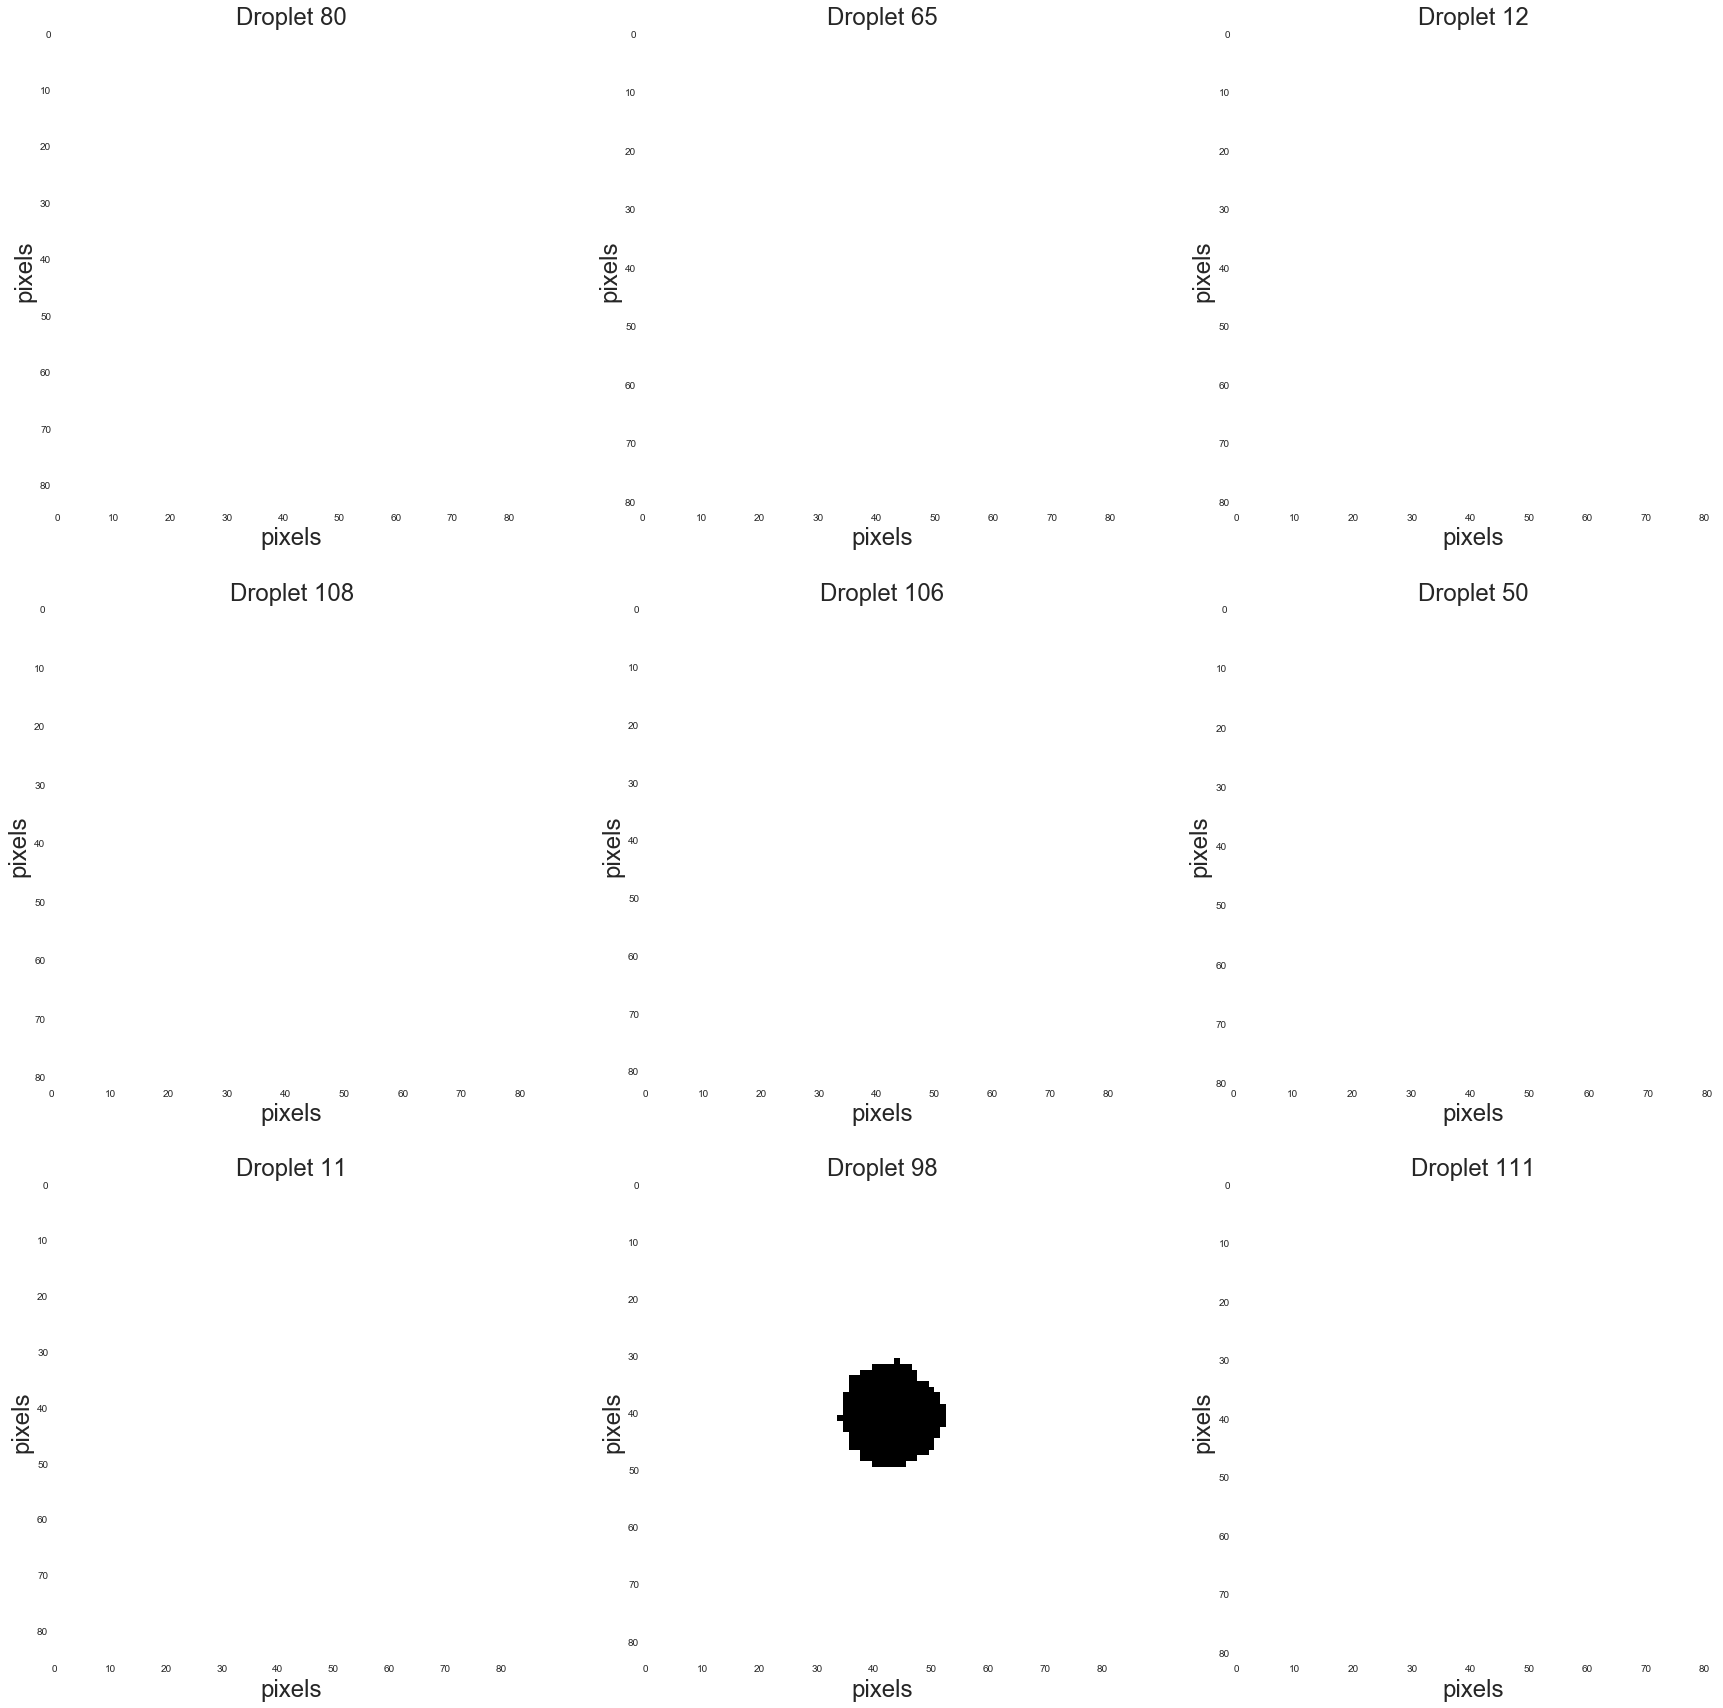

In [149]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            selection = random_values[i, j]
            ax[i, j].imshow(gfp_droplet_props[selection].intensity_image > 150,
                           cmap=plt.cm.Greys)
            
            ax[i, j].set_title("Droplet %i" % selection, size=24)
            ax[i, j].set_xlabel('pixels', size=24)
            ax[i, j].set_ylabel('pixels', size=24)
    plt.show()

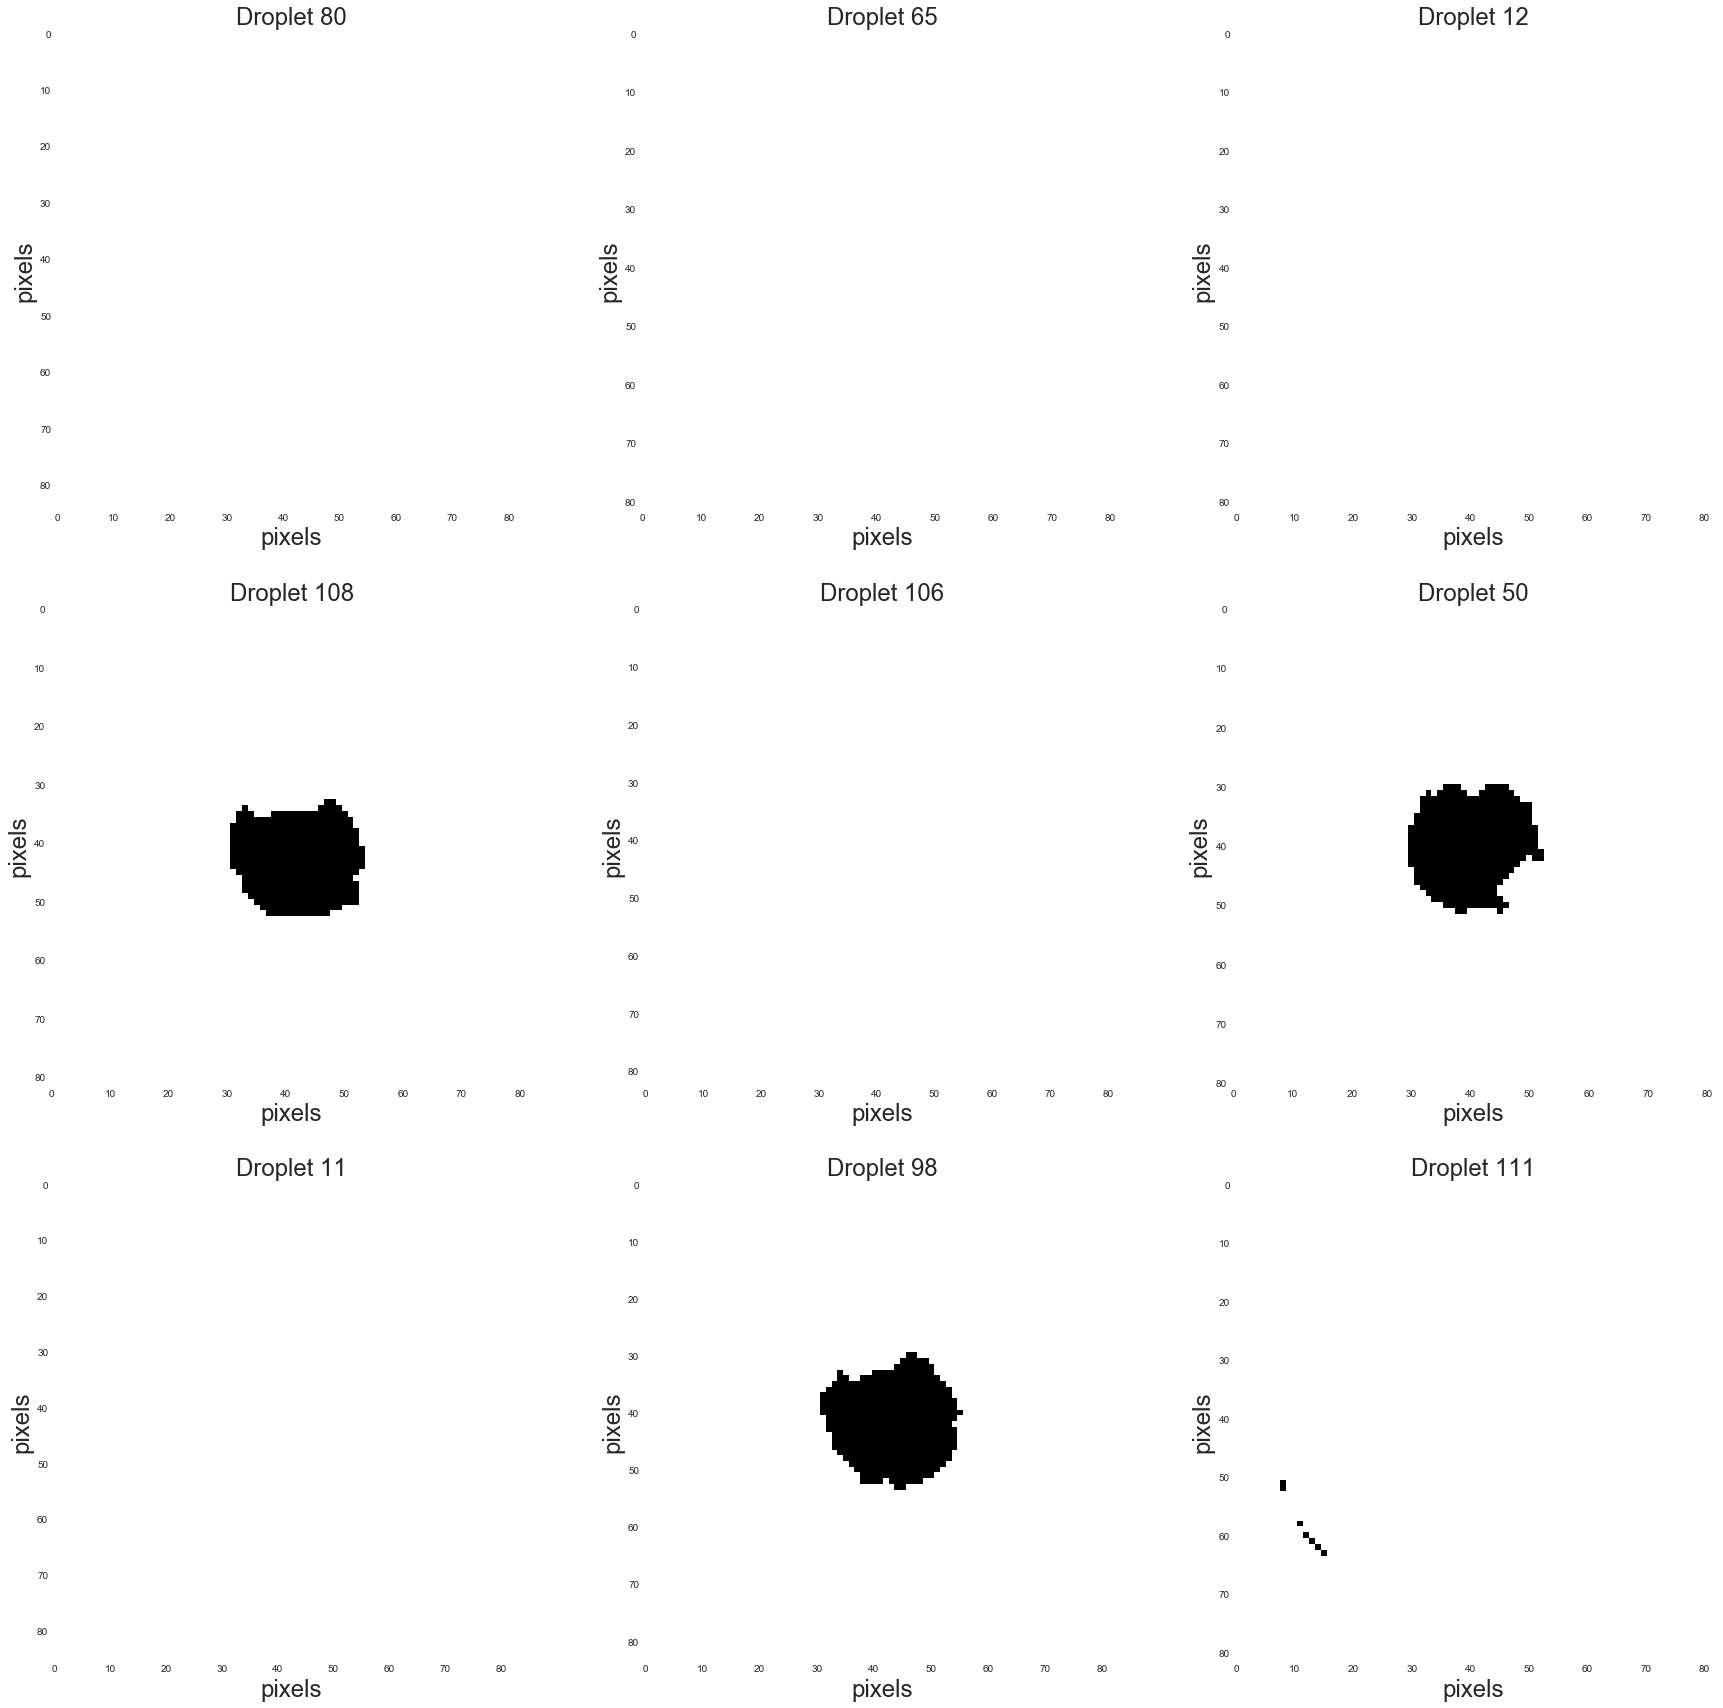

In [150]:
# List to save black-white thesholded cells
bw_droplets = {}
gfp_droplets = {}

# Show the initial random droplets
with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            # Select droplet region
            selection = random_values[i, j]
            temp_image = bright_droplet_props[selection].intensity_image
            temp_gfp_image = gfp_droplet_props[selection].intensity_image
            droplet_mask = bright_droplet_props[selection].image
            # apply median filter 
            #temp_image = skimage.filters.gaussian(temp_image)
            primary_radius = bright_droplet_props[selection].minor_axis_length / 2 
            new_radius = primary_radius - 5
            
            if len(droplet_mask) < len(droplet_mask[0]):
                center_x = bright_droplet_props[selection].minor_axis_length / 2
                center_y = bright_droplet_props[selection].major_axis_length / 2
            else:
                center_x = bright_droplet_props[selection].major_axis_length / 2
                center_y = bright_droplet_props[selection].minor_axis_length / 2
            
            new_mask = np.zeros(droplet_mask.shape)
            for x, row in enumerate(new_mask):
                for y, pixel in enumerate(row):
                    dist_x = center_x - x
                    dist_y = center_y - y
                    dist = np.sqrt(dist_x ** 2 + dist_y ** 2)
                    if dist < new_radius:
                        new_mask[x, y] = 1
            
            elevation_map = skimage.filters.sobel(temp_image,droplet_mask)
            #print(elevation_map.max())
            #closing(broken_line, square(3))
            # The background needs to be set to something that won't weight the thresholding
            # Perform a Scharr operation on the no cell droplet
            #cell_droplet_temp_scharr = skimage.filters.scharr(temp_image, droplet_mask)
            # Otsu threshold the scharr image
            cell_droplet_thresh = skimage.filters.threshold_otsu(elevation_map)
            edges = elevation_map > cell_droplet_thresh
            edges = skimage.morphology.erosion(edges)
            # Label the parts of the image and threshold if radius 
            label = skimage.measure.label(edges, background=0)
            edge_props = skimage.measure.regionprops(label, temp_image)
            image_dimensions = temp_image.shape
            blank_background= np.zeros(image_dimensions)
            #print('Droplet %d' % (i*3 + j))
            for index, prop in enumerate(edge_props):
                cutoff = prop.extent
                #print(prop.equivalent_diameter, cutoff)
                if prop.area > 10:
                    #print(prop.area)
                    temp_seg = label==index+1
                    filled_seg = temp_seg
                    blank_background = blank_background + filled_seg
                    
            # Remove outer ring
            cells = blank_background * new_mask
            cells = skimage.morphology.dilation(cells)
            cells = skimage.morphology.closing(cells)
            cells = ndi.binary_fill_holes(cells)
            cells = skimage.morphology.erosion(cells)
            cells = skimage.morphology.erosion(cells)
            # Plot the thresholded image
            ax[i, j].imshow(cells, cmap=plt.cm.Greys)
            ax[i, j].set_title("Droplet %i" % selection, size=24)
            ax[i, j].set_xlabel('pixels', size=24)
            ax[i, j].set_ylabel('pixels', size=24)
    plt.show()

In [212]:
# List to save black-white thesholded cells
whole_droplets = []
bw_droplets = []
gfp_droplets = []
for i in range(number_droplets):
    # Add brightfield image and gfp to lists
    whole_droplets.append(bright_droplet_props[i].intensity_image)
    gfp_droplets.append((gfp_droplet_props[i].intensity_image > 150) * gfp_droplet_props[i].intensity_image)
    # Define the brightfield image
    temp_image = bright_droplet_props[i].intensity_image
    droplet_mask = bright_droplet_props[i].image
    # Define the inner radius of the droplet
    primary_radius = bright_droplet_props[i].minor_axis_length / 2 
    new_radius = primary_radius - 5

    if len(droplet_mask) < len(droplet_mask[0]):
        center_x = bright_droplet_props[i].minor_axis_length / 2
        center_y = bright_droplet_props[i].major_axis_length / 2
    else:
        center_x = bright_droplet_props[i].major_axis_length / 2
        center_y = bright_droplet_props[i].minor_axis_length / 2

    new_mask = np.zeros(droplet_mask.shape)
    for x, row in enumerate(new_mask):
        for y, pixel in enumerate(row):
            dist_x = center_x - x
            dist_y = center_y - y
            dist = np.sqrt(dist_x ** 2 + dist_y ** 2)
            if dist < new_radius:
                new_mask[x, y] = 1

    elevation_map = skimage.filters.sobel(temp_image,droplet_mask)
    # Otsu threshold the scharr image
    cell_droplet_thresh = skimage.filters.threshold_otsu(elevation_map)
    edges = elevation_map > cell_droplet_thresh
    edges = skimage.morphology.erosion(edges)
    # Label the parts of the image and threshold if radius 
    label = skimage.measure.label(edges, background=0)
    edge_props = skimage.measure.regionprops(label, temp_image)
    image_dimensions = temp_image.shape
    blank_background= np.zeros(image_dimensions)
    #print('Droplet %d' % (i*3 + j))
    for index, prop in enumerate(edge_props):
        cutoff = prop.extent
        #print(prop.equivalent_diameter, cutoff)
        if prop.area > 10:
            #print(prop.area)
            temp_seg = label==index+1
            filled_seg = temp_seg
            blank_background = blank_background + filled_seg

    # Remove outer ring
    cells = blank_background * new_mask
    cells = skimage.morphology.dilation(cells)
    cells = skimage.morphology.closing(cells)
    cells = ndi.binary_fill_holes(cells)
    cells = skimage.morphology.erosion(cells)
    cells = skimage.morphology.erosion(cells)
    # Append the cells image to the list
    bw_droplets.append(cells)

In [213]:
# Find the number of cells
print(number_droplets)
count = 0
for i in range(number_droplets):
    num_cells = bw_droplets[i].max()
    count += num_cells
print(count)

138
28


In [214]:
count = 0
for i in range(number_droplets):
    num_cells = gfp_droplets[i].max()
    count += num_cells
print(count)

1461


In [215]:
# Results of the analysis
Group_2_droplets = np.array([138, 139, 136])
Group_2_cells = np.array([28, 58, 106])
Group_2_infected = np.array([15, 8, 20])

Group_3_droplets = np.array([132, 136, 139])
Group_3_cells = np.array([47, 37, 40])
Group_3_infected = np.array([10, 11, 15])

Group_4_droplets = np.array([154])
Group_4_cells = np.array([52])
Group_4_infected = np.array([0])

In [216]:
Group_2_cells_per_drop = np.true_divide(Group_2_cells, Group_2_droplets)
Group_3_cells_per_drop = np.true_divide(Group_3_cells, Group_3_droplets)
Group_4_cells_per_drop = np.true_divide(Group_4_cells, Group_4_droplets)

In [217]:
print('Group 2, average number of cells per droplet: %f' % Group_2_cells_per_drop.mean())
print('Group 3, average number of cells per droplet: %f' % Group_3_cells_per_drop.mean())
print('Group 4, average number of cells per droplet: %f' % Group_4_cells_per_drop.mean())

Group 2, average number of cells per droplet: 0.466526
Group 3, average number of cells per droplet: 0.305296
Group 4, average number of cells per droplet: 0.337662


In [218]:
Group_2_infected_per_cell = np.true_divide(Group_2_infected, Group_2_cells)
Group_3_infected_per_cell = np.true_divide(Group_3_infected, Group_3_cells)
Group_4_infected_per_cell = np.true_divide(Group_4_infected, Group_4_cells)

In [219]:
print('Group 2, percentage of infected: %f' % Group_2_infected_per_cell.mean())
print('Group 3, percentage of infected: %f' % Group_3_infected_per_cell.mean())
print('Group 4, percentage of infected: %f' % Group_4_infected_per_cell.mean())

Group 2, percentage of infected: 0.287442
Group 3, percentage of infected: 0.295021
Group 4, percentage of infected: 0.000000


These rough results are good as the MOI of the system is 0.3 and group 4 only included the DIP, which should not be propagating by itself. The next result to find is the variation in the intensity of each GFP cell.

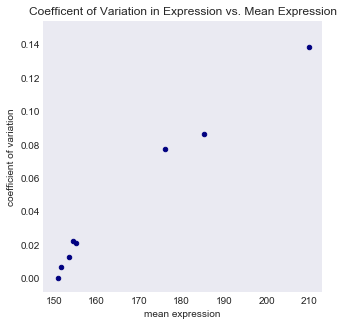

In [220]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for image in gfp_droplets:
        if image.max() != 0:
            intensities = []
            for row in image:
                for pixel in row:
                    if pixel != 0:
                        intensities.append(pixel)
            ints = np.array(intensities)
            
            ax.scatter(ints.mean(), ints.std() / ints.mean(), color='navy', s=20)
    plt.title('Coefficent of Variation in Expression vs. Mean Expression')
    plt.ylabel('coefficient of variation')
    plt.xlabel('mean expression')
    plt.show()

In [156]:
gfp_droplets[98].var()

1212.908423493169

In [225]:
def segment(filename):
    
    # Read in the brightfield and GFP images
    image_bright = skimage.io.imread(filename)[:, :, 0]
    image_gfp = skimage.io.imread(filename)[:, :, 1]
    # Find the Otsu threshold
    bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

    # Label thesholded images
    bright_threshold = image_bright > bright_thresh_otsu
    image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)

    # Get the properties of the labeled regions
    image_props = skimage.measure.regionprops(image_labeled)
    
    # Create a blank region of the original image
    image_dimensions = image_bright.shape
    blank_background= np.zeros(image_dimensions)
    # Go through props
    for index, prop in enumerate(image_props):
        # If the region properties are within the threshold
        if prop.area >= 400 and prop.eccentricity <= 0.5:
            # Select the region
            temp_seg = image_labeled==index+1
            filled_seg = temp_seg
            # Add the temp region
            blank_background = blank_background + filled_seg
    
    # Fill the holes of the image
    image_droplets = ndi.binary_fill_holes(blank_background)
    
    # From the filled droplets, create labeled regions with properties
    labeled_droplets, number_droplets = skimage.measure.label(image_droplets, background=0, return_num=True)
    bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
    gfp_droplet_props = skimage.measure.regionprops(labeled_droplets, image_gfp)
    # List to save black-white thesholded cells
    whole_droplets = []
    bw_droplets = []
    gfp_droplets = []
    for i in range(number_droplets):
        # Add brightfield image and gfp to lists
        whole_droplets.append(bright_droplet_props[i].intensity_image)
        gfp_droplets.append((gfp_droplet_props[i].intensity_image > 150) * gfp_droplet_props[i].intensity_image)
        # Define the brightfield image
        temp_image = bright_droplet_props[i].intensity_image
        droplet_mask = bright_droplet_props[i].image
        # Define the inner radius of the droplet
        primary_radius = bright_droplet_props[i].minor_axis_length / 2 
        new_radius = primary_radius - 5

        if len(droplet_mask) < len(droplet_mask[0]):
            center_x = bright_droplet_props[i].minor_axis_length / 2
            center_y = bright_droplet_props[i].major_axis_length / 2
        else:
            center_x = bright_droplet_props[i].major_axis_length / 2
            center_y = bright_droplet_props[i].minor_axis_length / 2

        new_mask = np.zeros(droplet_mask.shape)
        for x, row in enumerate(new_mask):
            for y, pixel in enumerate(row):
                dist_x = center_x - x
                dist_y = center_y - y
                dist = np.sqrt(dist_x ** 2 + dist_y ** 2)
                if dist < new_radius:
                    new_mask[x, y] = 1

        elevation_map = skimage.filters.sobel(temp_image,droplet_mask)
        # Otsu threshold the scharr image
        cell_droplet_thresh = skimage.filters.threshold_otsu(elevation_map)
        edges = elevation_map > cell_droplet_thresh
        edges = skimage.morphology.erosion(edges)
        # Label the parts of the image and threshold if radius 
        label = skimage.measure.label(edges, background=0)
        edge_props = skimage.measure.regionprops(label, temp_image)
        image_dimensions = temp_image.shape
        blank_background= np.zeros(image_dimensions)
        #print('Droplet %d' % (i*3 + j))
        for index, prop in enumerate(edge_props):
            cutoff = prop.extent
            #print(prop.equivalent_diameter, cutoff)
            if prop.area > 10:
                #print(prop.area)
                temp_seg = label==index+1
                filled_seg = temp_seg
                blank_background = blank_background + filled_seg

        # Remove outer ring
        cells = blank_background * new_mask
        cells = skimage.morphology.dilation(cells)
        cells = skimage.morphology.closing(cells)
        cells = ndi.binary_fill_holes(cells)
        cells = skimage.morphology.erosion(cells)
        cells = skimage.morphology.erosion(cells)
        # Append the cells image to the list
        bw_droplets.append(cells)
    
    return whole_droplets, gfp_droplets, bw_droplets

In [226]:
# Lists to store values in
group_2_images = []
group_3_images = []

for group_2_name in group_2:
    group_2_images.append(segment(group_2_name))
    
for group_3_name in group_3:
    group_3_images.append(segment(group_3_name))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.


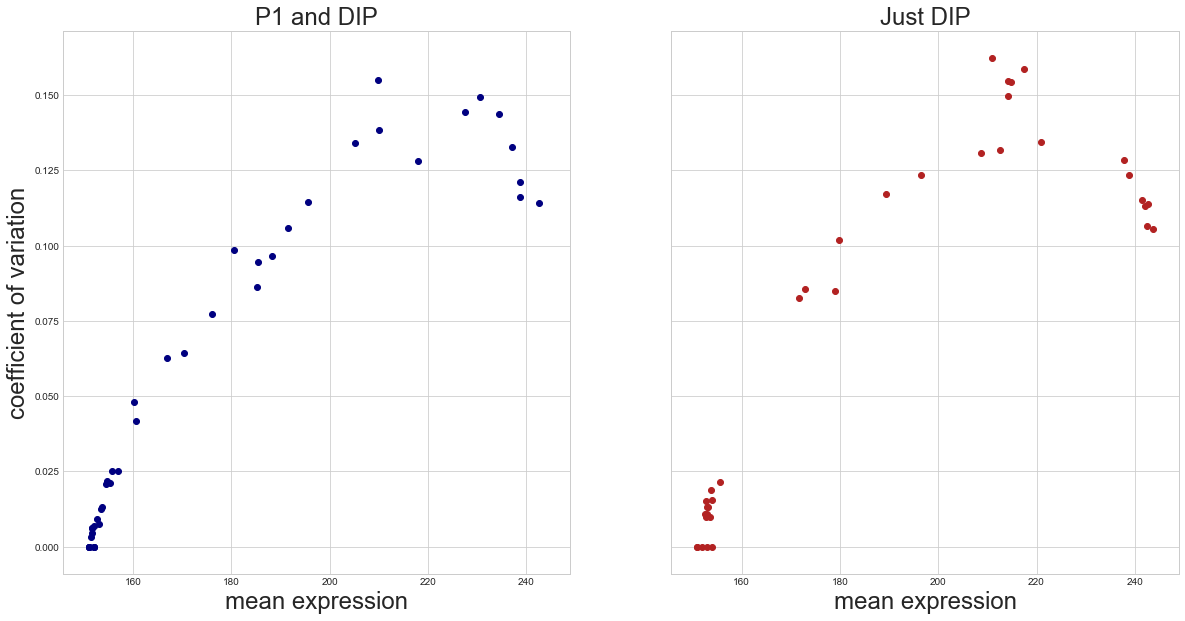

In [237]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)
    for i in range(len(group_2_images)):
        for j in range(len(group_2_images[i][1])):
            image = group_2_images[i][1][j]
            intensities = []
            if image.max() != 0:
                for row in image:
                    for pixel in row:
                        if pixel != 0:
                            intensities.append(pixel)
            ints = np.array(intensities)
            ax[0].scatter(ints.mean(), ints.std()/ints.mean(), color='navy')
    for i in range(len(group_3_images)):
        for j in range(len(group_3_images[i][1])):
            image = group_3_images[i][1][j]
            intensities = []
            if image.max() != 0:
                for row in image:
                    for pixel in row:
                        if pixel != 0:
                            intensities.append(pixel)
            ints = np.array(intensities)
            ax[1].scatter(ints.mean(), ints.std()/ints.mean(), color='firebrick')
    ax[0].set_title('P1 and DIP', size=24)
    ax[1].set_title('Just DIP', size=24)
    ax[0].set_ylabel('coefficient of variation', size=24)
    ax[0].set_xlabel('mean expression', size=24)
    ax[1].set_xlabel('mean expression', size=24)
    plt.show()